In [1]:
import os
import pandas as pd
import numpy as np
import regex as re
from datetime import datetime, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf

import ast

# Source code downloaded
from vincenty import vincenty_inverse
from tqdm import tqdm
pd.set_option('display.max_columns', 100)

# Cleaning EPA Data - Creating the condensed .csv files

In [2]:
current_dir = os.getcwd()
NOAA_dir = current_dir + r'\NOAA Weather Data'
EPA_dir = current_dir + r'\EPA Ozone Data'

In [ ]:
zip_files = os.listdir(EPA_dir + r'\Raw EPA Data')


In [ ]:
def create_ozone_id(statelist, countylist, sitelist):
    """
    Helper function for creating ozoneID's based on an EPA dataset
    
    returns: 3 lists appended together into tuples to be added into a column
    """
    return [(a,b,c) for a, b, c in zip(statelist, countylist, sitelist)]

def append_ozone_id(ozone_df):
    """
    Creates a copy of the dataframe and adds a new column that concatenates the state code, county code, and site number
    into a tuple to make an individual identifier for each ozone reporting location in that year. 
    
    returns: dataframe with ozoneID
    """
    temp = ozone_df.copy() 
    temp["ozoneID"] = create_ozone_id(temp["State Code"], temp["County Code"], temp["Site Num"])
    return temp

In [ ]:
time_period = ['09:00', '10:00', '11:00', '12:00', '13:00', '14:00', 
                      '15:00', '16:00', '17:00', '18:00', '19:00', '20:00']

def monitor_day_filter(grouped_dataframe):
    """
    Used in split-apply-combine after grouping by monitor-day in order to filter out days that have 
    less than 9 observations in the hours from 9am to 9pm
    """
    times = grouped_dataframe["Time Local"]
    indicator = [time in time_period for time in times]
    return sum(indicator) >= 9

## Construct 2 measures of ozone concentrations at the monitor-day level

- Daily Maximum: Groupby date, then return the maximum of that day

- Daily 8-hour Maximum: Groupby date, then average hours 0-8, 8-4, 4-12, return the maximum of that 

- Disqualify all monitor-days for which observations are not recorded for at least 9 hours between 9AM and 9PM, disqualify all monitors that have less than 75% of the days recorded from June1 to August 31,

- Disqualify monitors that are in counties close to other counties that have more stringent regulation (?????) 

Do this in one group by, write an apply function to return both of these as a new data frame per date. 

In [ ]:
def classify_time(time_str):
    time_int = int(time_str[0:2])
    if time_int < 8:
        return 1
    elif 8 <= time_int < 16:
        return 2
    elif  16 <= time_int:
        return 3
    else:
        raise ValueError('Time Local date was invalid?') 

def calculate_max_8hrmax(grouped_dataframe):
    """
    Used in split-apply-combine after grouping by monitor-day - calculate the maximum of the day as well as the 
    8 hour maximum - 8 hour maximum 
    """
       
    grouped_dataframe["Time Chunk"] = grouped_dataframe["Time Local"].apply(classify_time)
    
    samples_all = grouped_dataframe["Sample Measurement"]
    
    mean_1 = np.mean(grouped_dataframe.loc[grouped_dataframe["Time Chunk"] == 1, "Sample Measurement"])
    mean_2 = np.mean(grouped_dataframe.loc[grouped_dataframe["Time Chunk"] == 2, "Sample Measurement"])
    mean_3 = np.mean(grouped_dataframe.loc[grouped_dataframe["Time Chunk"] == 3, "Sample Measurement"])
    
    # CHANGE THIS TO MAX FUCK 
    daily_max = np.max(samples_all)
    eight_hour_max = max(mean_1, mean_2, mean_3)
    
    output = grouped_dataframe.iloc[[0],:]
    
    output["Daily Max Ozone"] = daily_max
    output["Daily 8hr Mean Ozone"] = eight_hour_max
    return output
                        

In [ ]:
@np.vectorize
def is_summer(date_str):
    """
    Checks if a dat str (in the format of the tablse) is in the summer 
    """
    month = int(re.search(r'\d{4}-(\d{2})-\d{2}', date_str).group(1))
    return 6 <= month <= 8


def monitor_year_filter(grouped_ozone_id):
    """ 
    Used in split-apply-combine after grouping by monitor in order to filter out entire monitors that do not have 
    observations in 25% or more during the summer ozone months Do this after calculating the maximum and 8hr maximums 
    
    DO THIS BEFORE APPLYING MAX DATE BECAUSE MAX DATE SLOW AS HELL 
    """
    # 92 days between June 1 and August 31, need 75% observations or more == only accept if greater than or equal to 69
    dates = grouped_ozone_id["Date Local"].unique()
    return sum(is_summer(dates)) >= 69
   
    

### Creating the lists of state_code county_code pairs that need to be deleted  

In [ ]:
county_list = pd.read_stata(current_dir + "\Author Data\AER20090377_CountyList.dta")
county_list["fips"] = county_list["fips"].astype(int)
county_list = county_list.rename(columns = {"state_code": "State Code", "county_code":"County Code"})
county_list = county_list.drop(columns = "county_desc")
county_list.head()

In [ ]:
neighbor_list = pd.read_stata(current_dir + "\Author Data\AER20090377_NeighborData.dta")
neighbor_list.head()

In [ ]:
# If deleting too many values, then make this so that it only counts the neighbors that are == 1
neighbor_fips = neighbor_list["fips"].values

In [ ]:
def get_urban_df(year):
    """
    Returns the dataframe of the urban designations as extracted from "Getting Urban Designation.ipynb"|
    """
    assert 1989 <= year <= 2003, "Bad year input"
    df = pd.read_csv(current_dir + r"\Author Data\county_urban_designation\county_urban_designation_" + str(year) + ".csv")
    df["urban"] = [int(text[1]) for text in df["urban"]]
    return df
    

## For Loop Instructions 
- Read the csv, then append ozone_id to get the ozone_Ids
- First group by date and ozone_id and filter out monitor-dates using monitor-day-filter 
    - This will net us with a dataframe that only has monitor dates for enough observations in the 9 hours  
- Apply the calculate max-8hrmax function to grouped monitor-days 
    - This will result with each day ending up justb being a single observation with 2 new columns. 
- Now group by monitor and look at whether or not this year had enough values, return final data frame after filtering

In [ ]:
summer_output_folder_path = EPA_dir + r'\Filtered EPA Data\onlysummer\\' 
second_level_cleaning_folder_path = EPA_dir + r'\Filtered EPA Data\second_cleaning\\' 

In [ ]:
state_code_join = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
                   28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49,
                   50, 51, 53, 54, 55, 56]

In [ ]:
zip_files = os.listdir(EPA_dir + r'\Raw EPA Data')
zip_files

for filename in zip_files: 
    
    year = int(filename[13:17])
    
    if f"condensed_EPA_{year}.csv" in os.listdir(second_level_cleaning_folder_path):
        print(f"Skipping {year}. already done")
        continue
    else: 
        print(f"working on {year}")
        filepath = EPA_dir + r"\\Raw EPA Data\\" + filename 
        temp = pd.read_csv(filepath)
        print("read csv done!")
        
        print(f"appending_ozone_id for {filename}")
        temp = append_ozone_id(temp)
        
        
        
        print(f"filtering out Canada for {filename}")
         # IF THERE IS CANADA, DELETE THOSE ROWS LMAO 
        if "CC" in temp["State Code"].unique(): 
            temp = temp[temp["State Code"] != "CC"]
            temp["State Code"] = temp["State Code"].astype(int)
            
            
        # add information from county_list file -- add fips 
        temp = temp.merge(county_list.iloc[:,0:3], on = ["State Code", "County Code"]) # now we have a bunch of extra info but that's okay
        
        # remove counties that are in the neighbors list 
        neighbor_indicator = [county_fip not in neighbor_fips for county_fip in temp["fips"]]
        temp = temp[neighbor_indicator] 
        
        

        print(f"applying dayfilter for {filename}")
        temp = temp.groupby(["ozoneID", "Date Local"]).filter(monitor_day_filter)
        
        print(f"applying yearfilter for {filename}")
        temp = temp.groupby("ozoneID").filter(monitor_year_filter)
        
        print(f"calclating maxes for {filename}")
        temp = temp.groupby(["ozoneID", "Date Local"], group_keys=False).apply(calculate_max_8hrmax)
        
        
        
        
       
        
        
        # add urban designation - for missing observations with NaN, fill with zero.
        # 3 = suburban, 2 = rural, 1 = urban
        temp = temp.merge(get_urban_df(year), on = "ozoneID", how = "left").fillna({"urban":0})     
        
        
        # Remove unecessary columns
        temp = temp.drop(columns = ["Parameter Code", "POC", "Datum", "Parameter Name", "Sample Measurement",
                                    "Time Local", "Date GMT", "Time GMT", "Units of Measure", 
                                    "Uncertainty", "Qualifier", "Method Type", "Method Code", 
                                    "Method Name", "MDL", "Date of Last Change", "Time Chunk"])

        
        
        
        
        print(f"finished {filename}, exporting to csv! at second_level_cleaning")
        temp.to_csv(second_level_cleaning_folder_path + r"condensed_EPA_" + str(year) + ".csv")


# Cleaning NOAA Data + Joining with EPA Data + Also Fixing Urban

In [ ]:
current_dir = os.getcwd()
NOAA_dir = current_dir + r'\NOAA Weather Data'
EPA_dir = current_dir + r'\EPA Ozone Data'

filtered_EPA_dir = current_dir + r'/EPA Ozone Data/Filtered EPA Data/second_cleaning/'


In [ ]:
filtered_EPA_files = [file for file in os.listdir(filtered_EPA_dir) if file.endswith(".csv")]

In [ ]:
NOAA_files = [file for file in os.listdir(NOAA_dir) if file.endswith(".csv.gz")]

In [ ]:
us_station_codes = pd.read_csv(NOAA_dir + r"\us_station_codes.csv", index_col = 0).drop(columns = ["a", "b"])

In [ ]:
def get_ozoneID_coords(ozone_df):
    """
    Groups entire dataframe by ozoneID and then applies lambda function that extracts the first entry of Latitude, Longitude
    
    returns: a series indexed by ozoneID that gives back information that can then be indexed into using key's 'Latitude' and
    'Longitude'
    
    NOTE: WE CAN GET ALL UNIQUE OZONE ID FROM THIS OUTPUT'S INDEX using output.index
    """
    #first check that the required columns are there, otherwise print an error
    if all(column in ozone_df.columns for column in ["ozoneID", "Latitude", "Longitude"]):
        return ozone_df.groupby("ozoneID").apply(lambda gr: gr[["Latitude", "Longitude"]].iloc[0,:])
    else:
        raise Exception("one of the columns needed in ozoneID, Latitude, Longitude was missing")

In [ ]:
from vincenty import vincenty_inverse

def get_closest_stations(lat_long_pair, NOAA_info):
#     print("working on " + str(lat_long_pair))
    temp = NOAA_info.copy()
    temp["ozone_lat"] = lat_long_pair["Latitude"]
    temp["ozone_long"] = lat_long_pair["Longitude"]
    temp["vincenty_dist"] = [vincenty_inverse((a, b), (c, d)) for a, b, c, d in zip(temp["lat"], 
                                                                            temp["long"], 
                                                                            temp["ozone_lat"], 
                                                                            temp["ozone_long"])]
    sorted_distances = temp.sort_values("vincenty_dist")[["StationId","vincenty_dist"]].iloc[0:10, :]
    return sorted_distances.values.tolist()



def get_closest_stations_euclidian(lat_long_pair, NOAA_info):
#     print("working on " + str(lat_long_pair))
    temp = NOAA_info.copy()
    temp["ozone_lat"] = lat_long_pair["Latitude"]
    temp["ozone_long"] = lat_long_pair["Longitude"]
    temp["euclidian_dist"] = np.sqrt((np.array(temp["lat"]) - np.array(temp["ozone_lat"]))**2 + (np.array(temp["long"]) - np.array(temp["ozone_long"]))**2)
    
    sorted_distances = temp.sort_values("euclidian_dist")["StationId"].iloc[0:10]
    return sorted_distances.values.tolist()

In [ ]:
# finished code

joined_data_dir = current_dir + r'/Joined Data/'

headers = ["StationId", "Date", "Measurement", "Value", "Flag1", "Flag2", "Flag3", "Flag4"]
closest_station_col_name = dict(zip(range(10), ["station_" + str(i) for i in range(10)]))

for i in range(len(filtered_EPA_files)):
    EPA_file = filtered_EPA_files[i]
#     print(EPA_file)
    NOAA_file = NOAA_files[i]
#     print(NOAA_file)
    year = NOAA_file[0:4]
    
#     if False:
    if year + "EPA_NOAA_joined.csv" in os.listdir(joined_data_dir):
        print("Skipping " + year + ", already filtered data.")
        continue
    else:
        print("Working on " + year )
        
        print("Reading csvs")
        EPA_data = pd.read_csv(filtered_EPA_dir + EPA_file, low_memory = False, index_col = 0).drop(columns = ["urban"])
        NOAA_data = pd.read_csv(NOAA_dir + "\\" + NOAA_file, names = headers)
    
        # fixing urban
        print("Fixing urban")
        EPA_data = EPA_data.merge(get_urban_df(int(year)), on = "ozoneID", how = "left").fillna({"urban":0}) 
        
        print("Cleaning NOAA")

        # clean NOAA_data
        NOAA_data = NOAA_data[NOAA_data["StationId"].str.startswith("US")] # selecting only US data

 
        NOAA_data = NOAA_data[NOAA_data["Measurement"].str.contains("TMAX|TMIN|PRCP|SNOW")].drop(columns = ["Flag1", "Flag2", "Flag3", "Flag4"])# selecting only important values and dropping uncessesary rows

        NOAA_data["Datetime"] = pd.to_datetime(NOAA_data["Date"], format='%Y%m%d', errors='ignore') # adding datetime to NOAA_data 

        unique_station_ids = pd.DataFrame({"StationId":NOAA_data["StationId"].unique()})
        unique_station_ids = unique_station_ids.merge(us_station_codes, on = "StationId", how = "left").drop(columns = ["elev", "name"])

        
        # get closest stations of the available stations 
        closest_stations = {}
        ozone_ID_coords = get_ozoneID_coords(EPA_data)
        unique_ozone_ids = ozone_ID_coords.index

        print("Getting closest stations")
        for i in tqdm(range(len(unique_ozone_ids))):
            # check station ids for each of the entries
            ozone_id = unique_ozone_ids[i]
            ozone_station_coord = ozone_ID_coords.loc[ozone_id]
            #euclidian distance much faster but can use vincenty - just not vectorized 
            closest_stations[ozone_id] = get_closest_stations_euclidian(ozone_station_coord, unique_station_ids)

        closest_station_df = pd.DataFrame(closest_stations).T.rename(columns = closest_station_col_name)

        # start finding closest stations and figuring out the weathers

        EPA_data["Datetime"] = pd.to_datetime(EPA_data["Date Local"], format='%Y-%m-%d', errors='ignore')
        merged_EPA_data = EPA_data.merge(closest_station_df, left_on = "ozoneID", right_index = True)
        merged_EPA_data
    
        print("Getting weather values")
        for var in ["TMAX", "TMIN", "SNOW", "PRCP"]:
            #select smaller subset to use 
            need_weather = merged_EPA_data[["Datetime"] + ["station_" + str(i) for i in range(10)]]

            # work with one NOAA variable at a time
            NOAA_variable_data = NOAA_data[NOAA_data["Measurement"] == var].rename(columns = {"Value": var}).drop(columns = ["Measurement", "Date"])

            for i in tqdm(range(10)): 
                current_station = "station_" + str(i) 
                current_variable = var + "_" + str(i)
                temp = need_weather.merge(NOAA_variable_data, left_on = ["Datetime", current_station], right_on = ["Datetime", "StationId"],  how = "left")\
                    .drop(columns = ["StationId"])\
                    .rename(columns = {var:current_variable})
                need_weather = temp

            NOAA_values = need_weather.iloc[:, -10:].values.tolist()
            no_na_NOAA_vals = [[value for value  in row if value  == value ] for row in NOAA_values]
            EPA_data[var] = no_na_NOAA_vals

        print("exporting")
        EPA_data.to_csv(joined_data_dir + year + "EPA_NOAA_joined.csv")

    
    

    

# Adding on Indicators for Implementation of Regulation

Using data provided in the author's online appendix, we create indicators for which regulations were applied where

In [ ]:
current_dir = os.getcwd()
NOAA_dir = current_dir + r'\NOAA Weather Data'
EPA_dir = current_dir + r'\EPA Ozone Data'

joined_data_dir = current_dir + r'/Joined Data/'


In [ ]:
joined_csv_files = [file for file in os.listdir(joined_data_dir) if file.endswith(".csv")]

In [ ]:
treatment_indicators = pd.read_csv("treatment_indicators.csv")

In [ ]:
def get_first_value(x):
    temp = ast.literal_eval(x)
    if len(temp) > 0:
        return temp[0]
    else:
        return temp

for file in joined_csv_files:
    print("Working on " + file)
    if False:
#     if "final_" + file in os.listdir(current_dir + "/Final Data"):
        print(file + " already joined, skipping")
        continue
    else:
        temp_df = pd.read_csv(joined_data_dir + file, index_col = 0)
        # this step takes the longest - gets the first value from each of the list of weather variables
        temp_df[["TMAX", "TMIN", "SNOW", "PRCP"]] = temp_df[["TMAX", "TMIN", "SNOW", "PRCP"]].applymap(get_first_value)
        temp_df["Datetime"] = pd.to_datetime(temp_df["Datetime"])
        temp_df["year"] = pd.DatetimeIndex(temp_df["Datetime"]).year
        temp_df["month"] = pd.DatetimeIndex(temp_df["Datetime"]).month
        merged_df = temp_df.merge(treatment_indicators, on = ["fips", "month", "year"], how = "left")
        merged_df.to_csv(current_dir + "/Final Data/" + "final_" + file)
        
        
        

# Finishing Data Cleaning - Merging All Data

In [ ]:
final_data_dir = current_dir + r'/Final Data/' 

In [ ]:
final_csv_files = [file for file in os.listdir(final_data_dir) if file.endswith(".csv")]

In [ ]:
join_together = []
for file in final_csv_files:
    join_together.append(pd.read_csv(final_data_dir + file, index_col = 0))

In [ ]:
final = pd.concat(join_together)

In [ ]:
# final

In [ ]:
# obtained from author's .do files
state_code_join = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
                   28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49,
                   50, 51, 53, 54, 55, 56]

census_region_join = [3, 4, 4, 3, 4, 4, 1, 3, 3, 3, 3, 4, 4, 2, 2, 2, 2, 3, 3, 1, 3, 1, 2, 2, 3, 2, 4, 2, 4, 1, 1, 4,
              1, 3, 2, 2, 3, 4, 1, 1, 3, 2, 3, 3, 4, 1, 3, 4, 3, 2, 4]

state_census_map = dict(zip(state_code_join, census_region_join))

In [ ]:
# add census region

final["census_region"] = final["State Code"].map(state_census_map)

# remove mexico

indicator = [state_code in state_code_join for state_code in final["State Code"]]

final_data = final[indicator]



In [ ]:
final_data.to_csv("final_cleaned_data2.csv")


# Reproducing Author's Results

In [3]:
current_dir = os.getcwd()
NOAA_dir = current_dir + r'\NOAA Weather Data'
EPA_dir = current_dir + r'\EPA Ozone Data'

In [4]:
# final_data = pd.read_csv('final_cleaned_data.csv', index_col = 0)
final_data = pd.read_csv('final_cleaned_data2.csv')

C:\Users\Danny\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (16,17,18,19,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
final_data = final_data.drop(columns = ["Unnamed: 0"])

In [6]:
# created lagged temperature
final_data["Datetime"] = pd.to_datetime(final_data["Datetime"])
final_data["day_before"] = [date - timedelta(days=1) for date in final_data["Datetime"]]
lagged_weather = final_data[["TMAX", "TMIN", "SNOW", "PRCP", "ozoneID", "Datetime"]].rename(columns = {"TMAX":"lagged_TMAX", "TMIN":"lagged_TMIN", "SNOW":"lagged_SNOW", "PRCP":"lagged_PRCP", "Datetime":"day_before"})
merged_lagged_weather = final_data.merge(lagged_weather, on = ["ozoneID", "day_before"]).rename(columns = {"Daily Max Ozone":"max_ozone", "Daily 8hr Mean Ozone":"8hr_max_ozone"})


In [7]:
summer_months = [6, 7, 8]
summer_only_indicator = [month in summer_months for month in merged_lagged_weather["month"]]
summer_only = merged_lagged_weather.copy()[summer_only_indicator]

In [8]:
summer_only["ln_ozone"] = np.log(summer_only["max_ozone"])
summer_only["ln_8hr_ozone"] = np.log(summer_only["8hr_max_ozone"])
summer_only = summer_only.replace([np.inf, -np.inf], np.nan)

C:\Users\Danny\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
summer_only["day_of_week"] = summer_only["Datetime"].dt.day_name()
summer_only["day_of_year"] = summer_only["Datetime"].dt.day_of_year

In [10]:
income = pd.read_stata(current_dir + "/Author Data/AER20090377_IncomeData.dta").rename(columns = {"state_code": "State Code", "county_code":"County Code",})

In [11]:
summer_only = summer_only.merge(income, on = ["State Code", "County Code", "year"])

In [12]:
# fixed effects for Ozone Indicators are now removed - biggest culprit
ozone_means = summer_only[["ozoneID", "ln_ozone", "ln_8hr_ozone"]].groupby("ozoneID").mean()
ozone_means = ozone_means.rename(columns = {"ln_ozone":"ln_max_ozone_mean", "ln_8hr_ozone":"ln_8hr_max_ozone_mean"})
summer_only = summer_only.merge(ozone_means, left_on = "ozoneID", right_index = True)
summer_only["demeaned_ln_ozone_max"] = summer_only["ln_ozone"] - summer_only["ln_max_ozone_mean"]
summer_only["demeaned_ln_8hr_ozone_max"] = summer_only["ln_8hr_ozone"] - summer_only["ln_8hr_max_ozone_mean"]

In [ ]:
summer_only

# Difference In Difference 1 - Dependent Vars on Treatment + Monitor FE + Region and Year FE

## Simplifying Assumption : Only use states as fixed effects, not individual 

In [ ]:
# DD regression 1
dependent_vars = ["ln_ozone", "ln_8hr_ozone"]
treatment_vars = ["treat_rvpI", "treat_rvpII", "treat_rfg", "treat_CARB"]
independent_vars = ["year", "census_region", "State Code"]
control = summer_only.copy()[independent_vars]

In [ ]:
# creating census interacted with year for the first DD regression
control["year"] = control["year"].astype(str) 
control["census_region"] = control["census_region"].astype(int).astype(str) 
control["State Code"] = control["State Code"].astype(str) 
control["census_region_year_interaction"] = control["census_region"].str.cat(control["year"], sep=' + ')

In [ ]:
control = pd.get_dummies(control, drop_first = True)

In [ ]:
results = {}
for i in range(len(dependent_vars)):
    
    dependent_var = dependent_vars[i]
    print("working on dependent, " + dependent_var)
    results[dependent_var] = {}
    
    for j in range(len(treatment_vars)):
        
        treatment_var = treatment_vars[j]
        print("working on treatment, " + treatment_var)
        
        df = pd.concat([summer_only[dependent_var], summer_only[treatment_var], control], axis = 1)
        df = df.dropna(axis = 0, how = "any")

        y = df[dependent_var]
        X = df.drop(columns = [dependent_var])
        model = sm.OLS(y, X).fit()
        
        values = {"Point Estimate":model.params[treatment_var], 
                  "Standard Error":model.bse[treatment_var],
                  "P-Value":model.pvalues[treatment_var],
                  "R Squared":model.rsquared}
        results[dependent_var][treatment_var] = values


In [ ]:
result_df_1 = pd.DataFrame(results["ln_ozone"])
result_df_1 = result_df_1.applymap(lambda x: round(x, 4))
result_df_1 = result_df_1.T
index1 = result_df_1.index
index1.name = "ln_ozone"
result_df_1

In [ ]:
result_df_2 = pd.DataFrame(results["ln_8hr_ozone"])
result_df_2 = result_df_2.applymap(lambda x: round(x, 4))
result_df_2 = result_df_2.T
index2 = result_df_2.index
index2.name = "ln_8hr_ozone"
result_df_2

## no state fixed effects CANNOT DO, this will mess up everything

In [ ]:
# DD regression 1
dependent_vars = ["ln_ozone", "ln_8hr_ozone"]
treatment_vars = ["treat_rvpI", "treat_rvpII", "treat_rfg", "treat_CARB"]
independent_vars = ["year", "census_region"]
control = summer_only.copy()[independent_vars]

In [ ]:
# creating census interacted with year for the first DD regression
control["year"] = control["year"].astype(str) 
control["census_region"] = control["census_region"].astype(int).astype(str) 
# control["State Code"] = control["State Code"].astype(str) 
control["census_region_year_interaction"] = control["census_region"].str.cat(control["year"], sep=' + ')

In [ ]:
control = pd.get_dummies(control, drop_first = True)

In [ ]:
results = {}
for i in range(len(dependent_vars)):
    
    dependent_var = dependent_vars[i]
    print("working on dependent, " + dependent_var)
    results[dependent_var] = {}
    
    for j in range(len(treatment_vars)):
        
        treatment_var = treatment_vars[j]
        print("working on treatment, " + treatment_var)
        
        df = pd.concat([summer_only[dependent_var], summer_only[treatment_var], control], axis = 1)
        df = df.dropna(axis = 0, how = "any")

        y = df[dependent_var]
        X = df.drop(columns = [dependent_var])
        model = sm.OLS(y, X).fit()
        
        values = {"Point Estimate":model.params[treatment_var], 
                  "Standard Error":model.bse[treatment_var],
                  "P-Value":model.pvalues[treatment_var],
                  "R Squared":model.rsquared}
        results[dependent_var][treatment_var] = values


In [ ]:
result_df_1 = pd.DataFrame(results["ln_ozone"])
result_df_1 = result_df_1.applymap(lambda x: round(x, 4))
result_df_1 = result_df_1.T
index1 = result_df_1.index
index1.name = "ln_ozone"
result_df_1

In [ ]:
result_df_2 = pd.DataFrame(results["ln_8hr_ozone"])
result_df_2 = result_df_2.applymap(lambda x: round(x, 4))
result_df_2 = result_df_2.T
index2 = result_df_2.index
index2.name = "ln_8hr_ozone"
result_df_2

## Using new demeaned outcomes to get rid of individual ozone fixed effects

In [ ]:
# DD regression 1
dependent_vars = ["demeaned_ln_ozone_max", "demeaned_ln_8hr_ozone_max"]
treatment_vars = ["treat_rvpI", "treat_rvpII", "treat_rfg", "treat_CARB"]

In [ ]:
results2 = {}
for i in range(len(dependent_vars)):
    
    dependent_var = dependent_vars[i]
    print("working on dependent, " + dependent_var)
    results2[dependent_var] = {}
    
    for j in range(len(treatment_vars)):
        
        treatment_var = treatment_vars[j]
        print("working on treatment, " + treatment_var)
        
        model = smf.ols(f"{dependent_var}~ 1 + {treatment_var} + C(year)*C(census_region)", data = summer_only).fit() # ozone fixed effects are taken care of by demeaning
        
        values = {"Point Estimate":model.params[treatment_var], 
                  "Standard Error":model.bse[treatment_var],
                  "P-Value":model.pvalues[treatment_var],
                  "R Squared":model.rsquared}
        results2[dependent_var][treatment_var] = values


In [ ]:
result_df_1 = pd.DataFrame(results2["demeaned_ln_ozone_max"])
result_df_1 = result_df_1.applymap(lambda x: round(x, 4))
result_df_1 = result_df_1.T
index1 = result_df_1.index
index1.name = "demeaned_ln_ozone_max"
result_df_1

In [ ]:
result_df_2 = pd.DataFrame(results2["demeaned_ln_8hr_ozone_max"])
result_df_2 = result_df_2.applymap(lambda x: round(x, 4))
result_df_2 = result_df_2.T
index2 = result_df_2.index
index2.name = "demeaned_ln_8hr_ozone_max"
result_df_2

## Trying new regression with all of the treatments in the regression? 

In [ ]:
# DD regression 1
dependent_vars = ["demeaned_ln_ozone_max", "demeaned_ln_8hr_ozone_max"]
treatment_vars = ["treat_rvpI", "treat_rvpII", "treat_rfg", "treat_CARB"]

In [ ]:
results3 = {}
for i in range(len(dependent_vars)):
    
    dependent_var = dependent_vars[i]
    print("working on dependent, " + dependent_var)
    results3[dependent_var] = {}

    model = smf.ols(f"{dependent_var} ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region)", data = summer_only).fit() # ozone fixed effects are taken care of by demeaning
    
    values = {}
    for var in treatment_vars:
        values[f"Point Estimate {var}"] = model.params[var]
    for var in treatment_vars:
        values[f"Standard Error {var}"] = model.bse[var]
    for var in treatment_vars:
        values[f"P-Value {var}"] = model.pvalues[var]
    values["R Squared"] = model.rsquared
    results3[dependent_var] = values


In [ ]:
result_df_1 = pd.DataFrame(results3)
result_df_1 = result_df_1.applymap(lambda x: round(x, 4))
result_df_1 = result_df_1.T
index1 = result_df_1.index
index1.name = "treatment"
result_df_1

# Difference in Difference 2 - Dependent Vars on Treatment + Fixed Effects + Day of Week stuff + Weather Stuff (Stratify to make this more feasible?) 
- 1 is urban
- 2 is suburban
- 3 is rural 



- cubic tmax tmin
- tmax * tmin
- quadratics of rainfall, snowfall
- rainfall * tmax
- one day lags
- tmax * lagged tmax
- tmax * lagged tmin
- Interact all of tmax, tmin, rainfall, and snowfall with day of week dummies
- Also need to add day of week dummies


Main method: get all the covariates for all oberservations and then select the ones after we have all of them together so that we can then get rid of nans and infs for what we actually do want 

In [ ]:
def convert_to_nan(x):
    """Use this sepcifically on the weather dataframe so that we can use it"""
    if isinstance(x, float):
        return x
    else:
        return np.nan


# DD regression 2 WITH WEATHER NOW 
dependent_vars = ["ln_ozone", "ln_8hr_ozone"]
treatment_vars = ["treat_rvpI", "treat_rvpII", "treat_rfg", "treat_CARB"] 
fixed_effect_vars = ["year", "census_region", "State Code"] # drop state code because too much to regress
# weather is defined below
fixed_effects = summer_only.copy()[fixed_effect_vars]
 


In [ ]:
# get fixed effects columns
fixed_effects["year"] = fixed_effects["year"].astype(str) 
fixed_effects["census_region"] = fixed_effects["census_region"].astype(int).astype(str) 
fixed_effects["State Code"] = fixed_effects["State Code"].astype(str) 
fixed_effects["census_region_year_interaction"] = fixed_effects["census_region"].str.cat(fixed_effects["year"], sep=' + ')
fixed_effects = pd.get_dummies(fixed_effects)

In [ ]:
# create weather adjustments so that we can fix it later 
weather_vars = ["TMIN", "TMAX", "SNOW", "PRCP", "lagged_TMIN", "lagged_TMAX", "lagged_SNOW", "lagged_PRCP"]
weather = summer_only.copy()[weather_vars]
weather = weather.applymap(convert_to_nan).astype(float)

def apply_weather_mods(weather):
    """Calculates the required feature engineering for weather data"""
    weather_df = weather.copy()
    weather_df["TMIN2"] = weather_df["TMIN"]**2
    weather_df["TMAX2"] = weather_df["TMAX"]**2 
    weather_df["TMIN3"] = weather_df["TMIN"]**3 
    weather_df["TMAX3"] = weather_df["TMAX"]**3 
    weather_df["TMAX*TMIN"] = weather_df["TMIN"] *  weather_df["TMAX"]
    weather_df["PRCP2"] = weather_df["PRCP"]**2
    weather_df["SNOW2"] = weather_df["SNOW"]**2
    weather_df["TMAX*PRCP"] = weather_df["TMAX"] * weather_df["PRCP"]
    weather_df["TMAX*lagged_TMAX"] = weather_df["TMAX"] * weather_df["lagged_TMAX"]
    weather_df["TMAX*lagged_TMIN"] = weather_df["TMAX"] * weather_df["lagged_TMIN"]
    return weather_df

weather = apply_weather_mods(weather)

In [ ]:
# created weekday dummies 

weekday = pd.get_dummies(summer_only["day_of_week"], drop_first = True)

In [ ]:
# weekday interacted with TMAX, TMIN, SNOW, PRCP

interacted_df = []

for weather_var in ["TMAX", "TMIN", "SNOW", "PRCP"]:
    # multiply weather variable onto the weekday row wise 
    df = weekday.mul(summer_only[weather_var], axis = 0)
    df = df.rename(columns = lambda x: f"{x}*{weather_var}")
    interacted_df.append(df)
    
interacted_weather_weekday = pd.concat(interacted_df, axis = 1)
    

In [ ]:
results = {}

    
control_all = pd.concat([fixed_effects, weather, interacted_weather_weekday, weekday, summer_only["income"]], axis = 1)

for urban in [1, 2, 3]:
    print("working on urban, " + str(urban))
    results[urban] = {}
    
    urban_indicator = summer_only["urban"] == urban
    
    covariates_df = control_all[urban_indicator]
    
    for i in range(len(dependent_vars)):
        dependent_var = dependent_vars[i]
        print("working on dependent, " + dependent_var)
        results[urban][dependent_var] = {}
        
        outcome_df = summer_only[[dependent_var]][urban_indicator]
        
        for j in range(len(treatment_vars)):

            treatment_var = treatment_vars[j]
            print("working on treatment, " + treatment_var)
            treatment_df = summer_only[[treatment_var]][urban_indicator]

            df = pd.concat([outcome_df, treatment_df, covariates_df], axis = 1)
            df = df.dropna(axis = 0, how = "any")

            y = df[[dependent_var]].astype(float)
            X = df.drop(columns = [dependent_var]).astype(float)
            model = sm.OLS(y, X).fit()

            values = {"Point Estimate":model.params[treatment_var], 
                      "Standard Error":model.bse[treatment_var],
                      "P-Value":model.pvalues[treatment_var],
                      "R Squared":model.rsquared}
            results[urban][dependent_var][treatment_var] = values


In [ ]:
urban_results = results[1]

In [ ]:
# Max Ozone for Urban Strata
pd.DataFrame(urban_results["ln_ozone"]).T

In [ ]:
# 8hr Max Ozone for Urban Strata
pd.DataFrame(urban_results["ln_8hr_ozone"]).T

In [ ]:
suburban_results = results[2]

In [ ]:
# Max Ozone for Suburban Strata
pd.DataFrame(suburban_results["ln_ozone"]).T

In [ ]:
# 8hr Max Ozone for Suburban Strata
pd.DataFrame(suburban_results["ln_8hr_ozone"]).T

In [ ]:
rural_results = results[3]

In [ ]:
# Max Ozone for Rural Strata
pd.DataFrame(rural_results["ln_ozone"]).T

In [ ]:
# 8hr Max Ozone for Rural Strata
pd.DataFrame(rural_results["ln_8hr_ozone"]).T

## Redoing DD with demeaned ozoneID Robustness Check

In [ ]:
def convert_to_nan(x):
    """Use this sepcifically on the weather dataframe so that we can use it"""
    if isinstance(x, float):
        return x
    else:
        return np.nan

    
    
summer_only["TMAX"] = summer_only["TMAX"].apply(convert_to_nan) 
summer_only["TMIN"] = summer_only["TMIN"].apply(convert_to_nan) 
summer_only["SNOW"] = summer_only["SNOW"].apply(convert_to_nan) 
summer_only["PRCP"] = summer_only["PRCP"].apply(convert_to_nan) 
summer_only["lagged_TMIN"] = summer_only["lagged_TMIN"].apply(convert_to_nan) 
summer_only["lagged_TMAX"] = summer_only["lagged_TMAX"].apply(convert_to_nan) 
summer_only["lagged_SNOW"] = summer_only["lagged_SNOW"].apply(convert_to_nan) 
summer_only["lagged_PRCP"] = summer_only["lagged_PRCP"].apply(convert_to_nan) 



In [ ]:
formula_dd1 = "demeaned_ln_ozone_max ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region) + \
I(TMAX) + I(TMAX**2) + I(TMAX**3) + I(TMIN) + I(TMIN**2) + I(TMIN**3) + SNOW + PRCP + I(SNOW**2) + I(PRCP**2) + \
I(TMAX*TMIN) + I(PRCP*TMAX) + lagged_TMIN + lagged_TMAX + lagged_SNOW + lagged_PRCP + I(TMAX*lagged_TMAX) + I(TMAX*lagged_TMIN) + \
C(day_of_week)*TMAX + C(day_of_week)*TMIN + C(day_of_week)*SNOW + C(day_of_week)*PRCP + C(day_of_week)*C(census_region) + C(day_of_year)*C(census_region) + income" 

formula_dd12 = "demeaned_ln_ozone_max ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region) + \
I(TMAX) + I(TMAX**2) + I(TMAX**3) + I(TMIN) + I(TMIN**2) + I(TMIN**3) + SNOW + PRCP + I(SNOW**2) + I(PRCP**2) + \
I(TMAX*TMIN) + I(PRCP*TMAX) + lagged_TMIN + lagged_TMAX + lagged_SNOW + lagged_PRCP + I(TMAX*lagged_TMAX) + I(TMAX*lagged_TMIN)"

formula_dd13 = "demeaned_ln_ozone_max ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region) + \
I(TMAX) + I(TMAX**2) + I(TMIN) + I(TMIN**2) + SNOW + PRCP + I(SNOW**2) + I(PRCP**2) + \
I(TMAX*TMIN) + I(PRCP*TMAX) + lagged_TMIN + lagged_TMAX + lagged_SNOW + lagged_PRCP"

#last one is the simple model
formula_dd14 = "demeaned_ln_ozone_max ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region)"


In [ ]:
dd2_model1 = smf.ols(formula_dd1, data = summer_only).fit()

In [ ]:
values21 = {}
for var in treatment_vars:
    values21[f"Point Estimate {var}"] = dd2_model1.params[var]
for var in treatment_vars:
    values21[f"Standard Error {var}"] = dd2_model1.bse[var]
for var in treatment_vars:
    values21[f"P-Value {var}"] = dd2_model1.pvalues[var]

In [ ]:
dd2_model2 = smf.ols(formula_dd12, data = summer_only).fit()

In [ ]:
values22 = {}
for var in treatment_vars:
    values22[f"Point Estimate {var}"] = dd2_model2.params[var]
for var in treatment_vars:
    values22[f"Standard Error {var}"] = dd2_model2.bse[var]
for var in treatment_vars:
    values22[f"P-Value {var}"] = dd2_model2.pvalues[var]

In [ ]:
dd2_model3 = smf.ols(formula_dd13, data = summer_only).fit()

In [ ]:
values23 = {}
for var in treatment_vars:
    values23[f"Point Estimate {var}"] = dd2_model3.params[var]
for var in treatment_vars:
    values23[f"Standard Error {var}"] = dd2_model3.bse[var]
for var in treatment_vars:
    values23[f"P-Value {var}"] = dd2_model3.pvalues[var]

In [ ]:
dd2_model4 = smf.ols(formula_dd14, data = summer_only).fit()

In [ ]:
values24 = {}
for var in treatment_vars:
    values24[f"Point Estimate {var}"] = dd2_model4.params[var]
for var in treatment_vars:
    values24[f"Standard Error {var}"] = dd2_model4.bse[var]
for var in treatment_vars:
    values24[f"P-Value {var}"] = dd2_model4.pvalues[var]

In [ ]:
results = {"Model 1 (Most Complex)":values21, "Model 2 (No Time Variables)":values22, "Model 3 (No Weather Cubics)":values23, "Model 4 (No Weather)":values24}

In [ ]:
pd.DataFrame(results).T

## Redoing with 8hr Max as dependent variable 

In [ ]:
formula_dd2 = "demeaned_ln_8hr_ozone_max ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region) + \
I(TMAX) + I(TMAX**2) + I(TMAX**3) + I(TMIN) + I(TMIN**2) + I(TMIN**3) + SNOW + PRCP + I(SNOW**2) + I(PRCP**2) + \
I(TMAX*TMIN) + I(PRCP*TMAX) + lagged_TMIN + lagged_TMAX + lagged_SNOW + lagged_PRCP + I(TMAX*lagged_TMAX) + I(TMAX*lagged_TMIN) + \
C(day_of_week)*TMAX + C(day_of_week)*TMIN + C(day_of_week)*SNOW + C(day_of_week)*PRCP + C(day_of_week)*C(census_region) + C(day_of_year)*C(census_region) + income" 

formula_dd22 = "demeaned_ln_8hr_ozone_max ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region) + \
I(TMAX) + I(TMAX**2) + I(TMAX**3) + I(TMIN) + I(TMIN**2) + I(TMIN**3) + SNOW + PRCP + I(SNOW**2) + I(PRCP**2) + \
I(TMAX*TMIN) + I(PRCP*TMAX) + lagged_TMIN + lagged_TMAX + lagged_SNOW + lagged_PRCP + I(TMAX*lagged_TMAX) + I(TMAX*lagged_TMIN)"

formula_dd23 = "demeaned_ln_8hr_ozone_max ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region) + \
I(TMAX) + I(TMAX**2) + I(TMIN) + I(TMIN**2) + SNOW + PRCP + I(SNOW**2) + I(PRCP**2) + \
I(TMAX*TMIN) + I(PRCP*TMAX) + lagged_TMIN + lagged_TMAX + lagged_SNOW + lagged_PRCP"

#last one is the simple model
formula_dd24 = "demeaned_ln_8hr_ozone_max ~ 1 + treat_rvpI + treat_rvpII + treat_rfg + treat_CARB + C(year)*C(census_region)"


In [ ]:
dd3_model1 = smf.ols(formula_dd2, data = summer_only).fit()

In [ ]:
values31 = {}
for var in treatment_vars:
    values31[f"Point Estimate {var}"] = dd3_model1.params[var]
for var in treatment_vars:
    values31[f"Standard Error {var}"] = dd3_model1.bse[var]
for var in treatment_vars:
    values31[f"P-Value {var}"] = dd3_model1.pvalues[var]

In [ ]:
dd3_model2 = smf.ols(formula_dd22, data = summer_only).fit()

In [ ]:
values32 = {}
for var in treatment_vars:
    values32[f"Point Estimate {var}"] = dd3_model2.params[var]
for var in treatment_vars:
    values32[f"Standard Error {var}"] = dd3_model2.bse[var]
for var in treatment_vars:
    values32[f"P-Value {var}"] = dd3_model2.pvalues[var]

In [ ]:
dd3_model3 = smf.ols(formula_dd23, data = summer_only).fit()

In [ ]:
values33 = {}
for var in treatment_vars:
    values33[f"Point Estimate {var}"] = dd3_model3.params[var]
for var in treatment_vars:
    values33[f"Standard Error {var}"] = dd3_model3.bse[var]
for var in treatment_vars:
    values33[f"P-Value {var}"] = dd3_model3.pvalues[var]

In [ ]:
dd3_model4 = smf.ols(formula_dd24, data = summer_only).fit()

In [ ]:
values34 = {}
for var in treatment_vars:
    values34[f"Point Estimate {var}"] = dd3_model4.params[var]
for var in treatment_vars:
    values34[f"Standard Error {var}"] = dd3_model4.bse[var]
for var in treatment_vars:
    values34[f"P-Value {var}"] = dd3_model4.pvalues[var]

In [ ]:
results2 = {"Model 1 (Most Complex)":values31, "Model 2 (No Time Variables)":values32, "Model 3 (No Weather Cubics)":values33, "Model 4 (No Weather)":values34}

In [ ]:
pd.DataFrame(results2).T

# Reanalyze - Doing a simple regression discontinuity analysis on just Los Angeles, Look at each plot individually

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
#LA County FIPS = 006037

la_county_all = merged_lagged_weather.copy()[merged_lagged_weather["fips"] == 6037]
la_county_summer = summer_only.copy()[summer_only["fips"] ==  6037]
la_county_all["ln_ozone"] = np.log(la_county_all["max_ozone"])
la_county_all["ln_8hr_ozone"] = np.log(la_county_all["8hr_max_ozone"])
la_county_all = la_county_all.replace([np.inf, -np.inf], np.nan)
la_county_all["day_of_week"] = la_county_all["Datetime"].dt.day_name()
la_county_all["day_of_year"] = la_county_all["Datetime"].dt.day_of_year

C:\Users\Danny\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
la_county_1601 = la_county_all.copy()[la_county_all["Site Num"] == 1601]
la_county_1601["TreatCARB"] = la_county_1601["TreatCARB"] == 1
la_county_1601["SNOW"] = la_county_1601["SNOW"].astype(float)

In [17]:
la_county_1601.head()

,State Code,County Code,Site Num,Latitude,Longitude,Date Local,Sample Measurement,State Name,County Name,ozoneID,fips,max_ozone,8hr_max_ozone,urban,Datetime,TMAX,TMIN,SNOW,PRCP,year,month,RVPStart,RVPEnd,RFGStart,RFGEnd,RegFlag,RVPI,treat_rvpII,treat_rfg,treat_rvpI,treat_CARB,TreatRFG,panelid,RFGStart2,RFGEnd2,TreatRVPII,RVPStart2,RVPEnd2,TreatCARB,TreatRFGCA,RVPCty,RFGCty,CARBCty,TreatRVPca,census_region,day_before,lagged_TMAX,lagged_TMIN,lagged_SNOW,lagged_PRCP,ln_ozone,ln_8hr_ozone,day_of_week,day_of_year
17894,6,37,1601,34.01407,-118.06056,1989-01-02,0.002,California,Los Angeles,"(6, 37, 1601)",6037,0.050,0.026750,2.0,1989-01-02,200.0,44.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,NaN,NaN,0.0,NaN,NaN,False,0.0,1.0,1.0,1.0,0.0,4.0,1989-01-01,189.0,56.0,0.0,25.0,-2.995732,-3.621221,Monday,2
17895,6,37,1601,34.01407,-118.06056,1989-01-03,0.002,California,Los Angeles,"(6, 37, 1601)",6037,0.010,0.003143,2.0,1989-01-03,178.0,89.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,NaN,NaN,0.0,NaN,NaN,False,0.0,1.0,1.0,1.0,0.0,4.0,1989-01-02,200.0,44.0,0.0,0.0,-4.605170,-5.762623,Tuesday,3
17896,6,37,1601,34.01407,-118.06056,1989-01-04,0.002,California,Los Angeles,"(6, 37, 1601)",6037,0.002,0.002000,2.0,1989-01-04,167.0,100.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,NaN,NaN,0.0,NaN,NaN,False,0.0,1.0,1.0,1.0,0.0,4.0,1989-01-03,178.0,89.0,0.0,0.0,-6.214608,-6.214608,Wednesday,4
17897,6,37,1601,34.01407,-118.06056,1989-01-05,0.002,California,Los Angeles,"(6, 37, 1601)",6037,0.020,0.015000,2.0,1989-01-05,156.0,133.0,0.0,25.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,NaN,NaN,0.0,NaN,NaN,False,0.0,1.0,1.0,1.0,0.0,4.0,1989-01-04,167.0,100.0,0.0,0.0,-3.912023,-4.199705,Thursday,5
17898,6,37,1601,34.01407,-118.06056,1989-01-06,0.010,California,Los Angeles,"(6, 37, 1601)",6037,0.030,0.026250,2.0,1989-01-06,122.0,44.0,0.0,81.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,NaN,NaN,0.0,NaN,NaN,False,0.0,1.0,1.0,1.0,0.0,4.0,1989-01-05,156.0,133.0,0.0,25.0,-3.506558,-3.640089,Friday,6


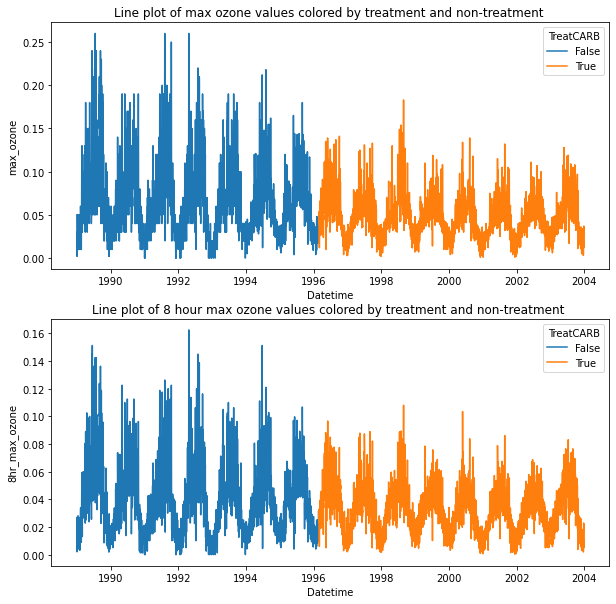

In [18]:
fig, [ax1, ax2] = plt.subplots(2,1,figsize = (10,10))

sns.lineplot(data = la_county_1601, x = "Datetime", y = "max_ozone", hue = "TreatCARB", ax = ax1)
ax1.set_title("Line plot of max ozone values colored by treatment and non-treatment ")


sns.lineplot(data = la_county_1601, x = "Datetime", y = "8hr_max_ozone", hue = "TreatCARB", ax = ax2)
ax2.set_title("Line plot of 8 hour max ozone values colored by treatment and non-treatment ")

fig.savefig("all_plot.png")

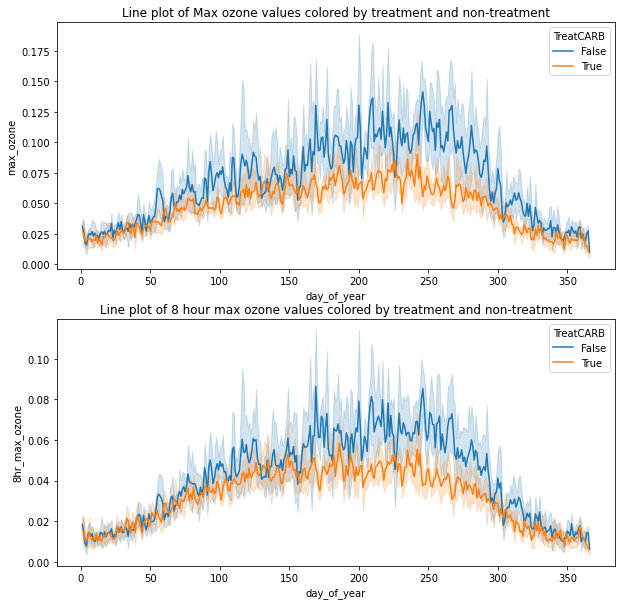

In [19]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize = (10,10))

sns.lineplot(data = la_county_1601, x = "day_of_year", y = "max_ozone", hue = "TreatCARB", ax = ax1)
ax1.set_title("Line plot of Max ozone values colored by treatment and non-treatment")

sns.lineplot(data = la_county_1601, x = "day_of_year", y = "8hr_max_ozone", hue = "TreatCARB", ax = ax2)
ax2.set_title("Line plot of 8 hour max ozone values colored by treatment and non-treatment")

fig.savefig("day_of_year_ozone.png")


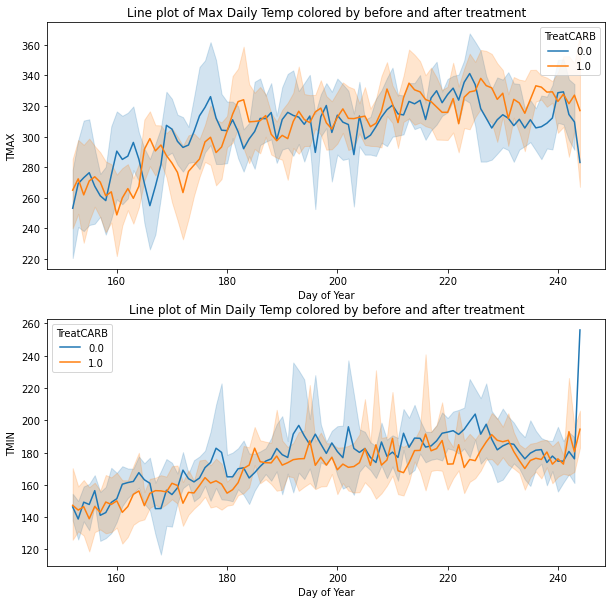

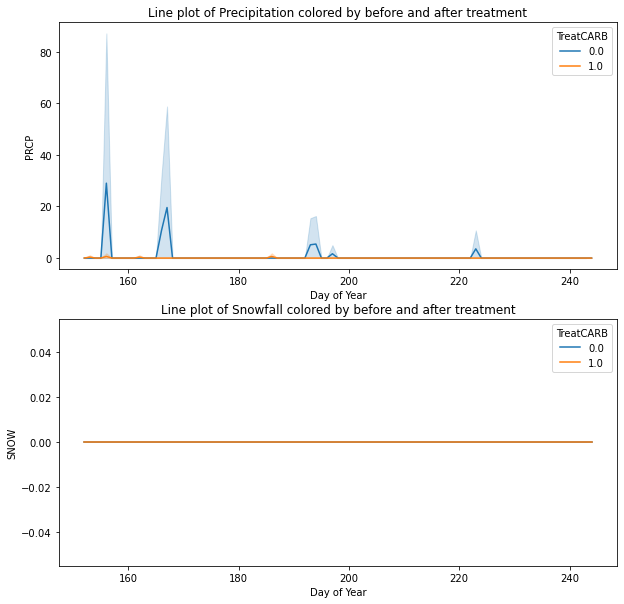

In [23]:
# to example the effect, let's just do difference in means lmao for the summer - main controls are all unchanged

#TMAX TMIN SNOW PRCP

la_county_summer_1601 = la_county_summer.copy()[la_county_summer["Site Num"] == 1601]
la_county_summer_1601["TMAX"] = la_county_summer_1601["TMAX"].astype(float)
la_county_summer_1601["TMIN"] = la_county_summer_1601["TMIN"].astype(float)
la_county_summer_1601["PRCP"] = la_county_summer_1601["PRCP"].astype(float)
la_county_summer_1601["SNOW"] = la_county_summer_1601["SNOW"].astype(float)



fig1, [ax1, ax2] = plt.subplots(2, 1, figsize = (10,10))
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMAX", hue = "TreatCARB", ax = ax1)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMIN", hue = "TreatCARB", ax = ax2)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "PRCP", hue = "TreatCARB", ax = ax3)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "SNOW", hue = "TreatCARB", ax = ax4)

ax1.set_title("Line plot of Max Daily Temp colored by before and after treatment")
ax2.set_title("Line plot of Min Daily Temp colored by before and after treatment")
# ax3.set_title("Line plot of Precipitation colored by before and after treatment")
# ax4.set_title("Line plot of Snowfall colored by before and after treatment")

ax1.set_xlabel("Day of Year")
ax2.set_xlabel("Day of Year")

fig2, [ax3, ax4] = plt.subplots(2, 1, figsize = (10,10))
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMAX", hue = "TreatCARB", ax = ax1)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMIN", hue = "TreatCARB", ax = ax2)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "PRCP", hue = "TreatCARB", ax = ax3)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "SNOW", hue = "TreatCARB", ax = ax4)

# ax1.set_title("Line plot of Max Daily Temp colored by before and after treatment")
# ax2.set_title("Line plot of Min Daily Temp colored by before and after treatment")
ax3.set_title("Line plot of Precipitation colored by before and after treatment")
ax4.set_title("Line plot of Snowfall colored by before and after treatment")


ax3.set_xlabel("Day of Year")
ax4.set_xlabel("Day of Year")



fig1.savefig("control_day_of_yeara.png")
fig2.savefig("control_day_of_yearb.png")


In [21]:
summer_days = la_county_summer_1601["day_of_year"].unique()
diff_max = []
diff_8hrmax = [] 
for i in summer_days:
    # calculate the mean of before and after and take the difference 
    day_i = la_county_summer_1601[la_county_summer_1601["day_of_year"] == i][["8hr_max_ozone", "max_ozone", "TreatCARB"]]
    before = day_i[day_i["TreatCARB"] == 0]
    after = day_i[day_i["TreatCARB"] == 1]
    mean_before_max = np.mean(before["max_ozone"])
    mean_before_8hrmax = np.mean(before["8hr_max_ozone"])
    mean_after_max = np.mean(after["max_ozone"])
    mean_after_8hrmax = np.mean(after["8hr_max_ozone"])
    
    diff_max.append(mean_after_max - mean_before_max)
    diff_8hrmax.append(mean_after_8hrmax - mean_before_8hrmax)
    
print(np.mean(diff_max), np.mean(diff_8hrmax))

-0.029568356374807984 -0.01602751658010875


In [22]:
summer_days = la_county_summer_1601["day_of_year"].unique()
diff_max = []
diff_8hrmax = []
diff_max_log = []
diff_8hrmax_log = []

for i in summer_days:
    # calculate the mean of before and after and take the difference 
    day_i = la_county_summer_1601[la_county_summer_1601["day_of_year"] == i][["8hr_max_ozone", "max_ozone", "TreatCARB"]]
    before = day_i[day_i["TreatCARB"] == 0]
    after = day_i[day_i["TreatCARB"] == 1]
    mean_before_max = np.mean(before["max_ozone"])
    mean_before_8hrmax = np.mean(before["8hr_max_ozone"])
    mean_after_max = np.mean(after["max_ozone"])
    mean_after_8hrmax = np.mean(after["8hr_max_ozone"])
    
    diff_max.append(mean_after_max - mean_before_max)
    diff_8hrmax.append(mean_after_8hrmax - mean_before_8hrmax)
     
    mean_before_max_l = np.mean(np.log(before["max_ozone"]))
    mean_before_8hrmax_l = np.mean(np.log(before["8hr_max_ozone"]))
    mean_after_max_l = np.mean(np.log(after["max_ozone"]))
    mean_after_8hrmax_l = np.mean(np.log(after["8hr_max_ozone"]))
    
    diff_max_log.append(mean_after_max_l - mean_before_max_l)
    diff_8hrmax_log.append(mean_after_8hrmax_l - mean_before_8hrmax_l)
    
print("max", np.mean(diff_max), "8hr max", np.mean(diff_8hrmax), "log_max", np.mean(diff_max_log), "log_8hr_max", np.mean(diff_8hrmax_log))


max -0.029568356374807984 8hr max -0.01602751658010875 log_max -0.31730198576305507 log_8hr_max -0.26174782533054564


# Reanalyze - Doing a simple regression discontinuity analysis on just Madison County, Illinoios 3007 , Look at each plot individually

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
#madison County FIPS = 17119

la_county_all = merged_lagged_weather.copy()[merged_lagged_weather["fips"] == 17119]
la_county_summer = summer_only.copy()[summer_only["fips"] ==  17119]
la_county_all["ln_ozone"] = np.log(la_county_all["max_ozone"])
la_county_all["ln_8hr_ozone"] = np.log(la_county_all["8hr_max_ozone"])
la_county_all = la_county_all.replace([np.inf, -np.inf], np.nan)
la_county_all["day_of_week"] = la_county_all["Datetime"].dt.day_name()
la_county_all["day_of_year"] = la_county_all["Datetime"].dt.day_of_year

In [28]:
la_county_1601 = la_county_all.copy()[la_county_all["Site Num"] == 3007]
la_county_1601["TreatRVPII"] = la_county_1601["TreatRVPII"] == 1
la_county_1601["SNOW"] = la_county_1601["SNOW"].astype(float)

In [29]:
la_county_1601.head()

,State Code,County Code,Site Num,Latitude,Longitude,Date Local,Sample Measurement,State Name,County Name,ozoneID,fips,max_ozone,8hr_max_ozone,urban,Datetime,TMAX,TMIN,SNOW,PRCP,year,month,RVPStart,RVPEnd,RFGStart,RFGEnd,RegFlag,RVPI,treat_rvpII,treat_rfg,treat_rvpI,treat_CARB,TreatRFG,panelid,RFGStart2,RFGEnd2,TreatRVPII,RVPStart2,RVPEnd2,TreatCARB,TreatRFGCA,RVPCty,RFGCty,CARBCty,TreatRVPca,census_region,day_before,lagged_TMAX,lagged_TMIN,lagged_SNOW,lagged_PRCP,ln_ozone,ln_8hr_ozone,day_of_week,day_of_year
85995,17,119,3007,38.860669,-90.105851,1989-01-02,0.016,Illinois,Madison,"(17, 119, 3007)",17119,0.024,0.019625,2.0,1989-01-02,6.0,-44.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,671.0,NaN,NaN,False,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1989-01-01,22.0,-56.0,8.0,20.0,-3.729701,-3.930951,Monday,2
85996,17,119,3007,38.860669,-90.105851,1989-01-03,0.011,Illinois,Madison,"(17, 119, 3007)",17119,0.025,0.021375,2.0,1989-01-03,6.0,-6.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,671.0,NaN,NaN,False,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1989-01-02,6.0,-44.0,0.0,0.0,-3.688879,-3.845533,Tuesday,3
85997,17,119,3007,38.860669,-90.105851,1989-01-04,0.023,Illinois,Madison,"(17, 119, 3007)",17119,0.024,0.019250,2.0,1989-01-04,56.0,-33.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,671.0,NaN,NaN,False,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1989-01-03,6.0,-6.0,0.0,0.0,-3.729701,-3.950244,Wednesday,4
85998,17,119,3007,38.860669,-90.105851,1989-01-05,0.009,Illinois,Madison,"(17, 119, 3007)",17119,0.013,0.009125,2.0,1989-01-05,44.0,-44.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,671.0,NaN,NaN,False,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1989-01-04,56.0,-33.0,0.0,0.0,-4.342806,-4.696737,Thursday,5
85999,17,119,3007,38.860669,-90.105851,1989-01-06,0.002,Illinois,Madison,"(17, 119, 3007)",17119,0.002,0.002000,2.0,1989-01-06,61.0,17.0,0.0,302.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,671.0,NaN,NaN,False,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1989-01-05,44.0,-44.0,0.0,0.0,-6.214608,-6.214608,Friday,6


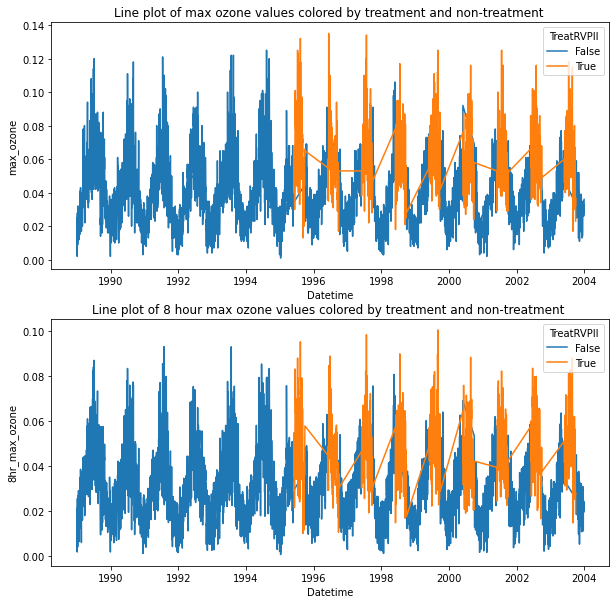

In [30]:
fig, [ax1, ax2] = plt.subplots(2,1,figsize = (10,10))

sns.lineplot(data = la_county_1601, x = "Datetime", y = "max_ozone", hue = "TreatRVPII", ax = ax1)
ax1.set_title("Line plot of max ozone values colored by treatment and non-treatment ")


sns.lineplot(data = la_county_1601, x = "Datetime", y = "8hr_max_ozone", hue = "TreatRVPII", ax = ax2)
ax2.set_title("Line plot of 8 hour max ozone values colored by treatment and non-treatment ")

fig.savefig("all_plot2.png")

Text(0.5, 69.00000000000009, 'Day of Year')

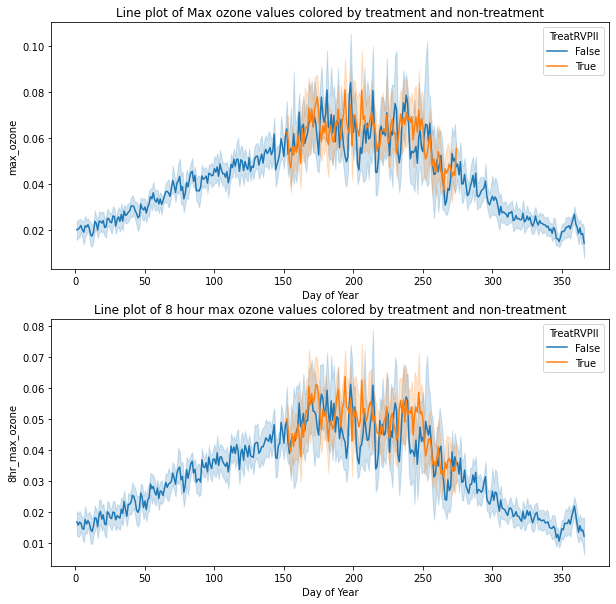

In [31]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize = (10,10))

sns.lineplot(data = la_county_1601, x = "day_of_year", y = "max_ozone", hue = "TreatRVPII", ax = ax1)
ax1.set_title("Line plot of Max ozone values colored by treatment and non-treatment")

sns.lineplot(data = la_county_1601, x = "day_of_year", y = "8hr_max_ozone", hue = "TreatRVPII", ax = ax2)
ax2.set_title("Line plot of 8 hour max ozone values colored by treatment and non-treatment")

fig.savefig("day_of_year_ozone2.png")

ax1.set_xlabel("Day of Year")
ax2.set_xlabel("Day of Year")



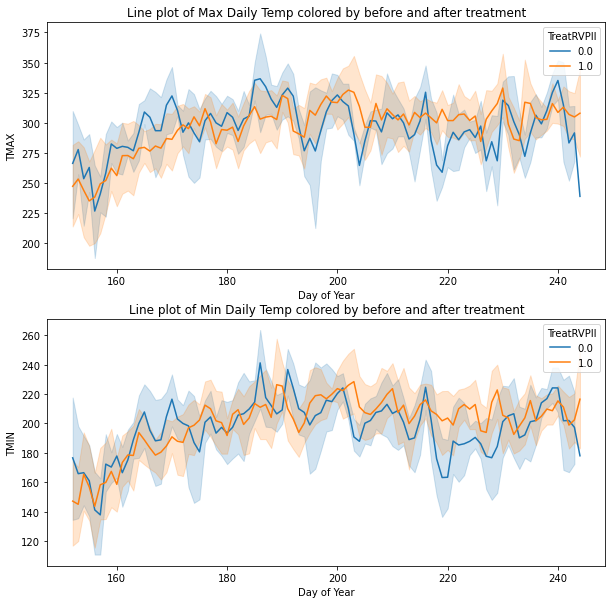

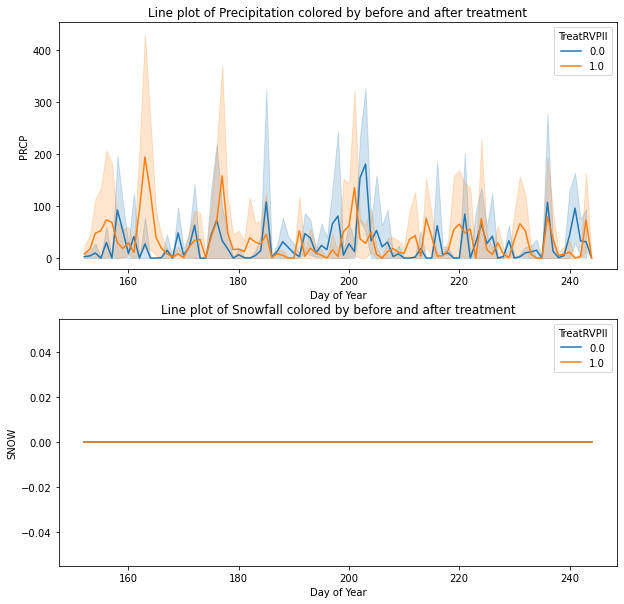

In [32]:
# to example the effect, let's just do difference in means lmao for the summer - main controls are all unchanged

#TMAX TMIN SNOW PRCP

la_county_summer_1601 = la_county_summer.copy()[la_county_summer["Site Num"] == 3007]
la_county_summer_1601["TMAX"] = la_county_summer_1601["TMAX"].astype(float)
la_county_summer_1601["TMIN"] = la_county_summer_1601["TMIN"].astype(float)
la_county_summer_1601["PRCP"] = la_county_summer_1601["PRCP"].astype(float)
la_county_summer_1601["SNOW"] = la_county_summer_1601["SNOW"].astype(float)



fig1, [ax1, ax2] = plt.subplots(2, 1, figsize = (10,10))
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMAX", hue = "TreatRVPII", ax = ax1)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMIN", hue = "TreatRVPII", ax = ax2)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "PRCP", hue = "TreatCARB", ax = ax3)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "SNOW", hue = "TreatCARB", ax = ax4)

ax1.set_title("Line plot of Max Daily Temp colored by before and after treatment")
ax2.set_title("Line plot of Min Daily Temp colored by before and after treatment")
# ax3.set_title("Line plot of Precipitation colored by before and after treatment")
# ax4.set_title("Line plot of Snowfall colored by before and after treatment")

ax1.set_xlabel("Day of Year")
ax2.set_xlabel("Day of Year")


ax3.set_xlabel("Day of Year")
ax4.set_xlabel("Day of Year")

fig2, [ax3, ax4] = plt.subplots(2, 1, figsize = (10,10))
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMAX", hue = "TreatCARB", ax = ax1)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMIN", hue = "TreatCARB", ax = ax2)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "PRCP", hue = "TreatRVPII", ax = ax3)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "SNOW", hue = "TreatRVPII", ax = ax4)

# ax1.set_title("Line plot of Max Daily Temp colored by before and after treatment")
# ax2.set_title("Line plot of Min Daily Temp colored by before and after treatment")
ax3.set_title("Line plot of Precipitation colored by before and after treatment")
ax4.set_title("Line plot of Snowfall colored by before and after treatment")

ax3.set_xlabel("Day of Year")
ax4.set_xlabel("Day of Year")


fig1.savefig("control_day_of_year2a.png")
fig2.savefig("control_day_of_year2b.png")


In [33]:
summer_days = la_county_summer_1601["day_of_year"].unique()
diff_max = []
diff_8hrmax = [] 
diff_max_log = []
diff_8hrmax_log = []

for i in summer_days:
    # calculate the mean of before and after and take the difference 
    day_i = la_county_summer_1601[la_county_summer_1601["day_of_year"] == i][["8hr_max_ozone", "max_ozone", "TreatRVPII"]]
    before = day_i[day_i["TreatRVPII"] == 0]
    after = day_i[day_i["TreatRVPII"] == 1]
    mean_before_max = np.mean(before["max_ozone"])
    mean_before_8hrmax = np.mean(before["8hr_max_ozone"])
    mean_after_max = np.mean(after["max_ozone"])
    mean_after_8hrmax = np.mean(after["8hr_max_ozone"])
    
    diff_max.append(mean_after_max - mean_before_max)
    diff_8hrmax.append(mean_after_8hrmax - mean_before_8hrmax)
    
     
    mean_before_max_l = np.mean(np.log(before["max_ozone"]))
    mean_before_8hrmax_l = np.mean(np.log(before["8hr_max_ozone"]))
    mean_after_max_l = np.mean(np.log(after["max_ozone"]))
    mean_after_8hrmax_l = np.mean(np.log(after["8hr_max_ozone"]))
    
    diff_max_log.append(mean_after_max_l - mean_before_max_l)
    diff_8hrmax_log.append(mean_after_8hrmax_l - mean_before_8hrmax_l)
    
print("max", np.mean(diff_max), "8hr max", np.mean(diff_8hrmax), "log_max", np.mean(diff_max_log), "log_8hr_max", np.mean(diff_8hrmax_log))

max 0.0020481780167264027 8hr max 0.0031208756827103604 log_max 0.03934907771369466 log_8hr_max 0.07487323748582439


# Reanalyze - Doing a simple regression discontinuity analysis on just Camden County, New Jersey site 1001 , Look at each plot individually

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
#Camden County FIPS = 34007

la_county_all = merged_lagged_weather.copy()[merged_lagged_weather["fips"] == 34007]
la_county_summer = summer_only.copy()[summer_only["fips"] ==  34007]
la_county_all["ln_ozone"] = np.log(la_county_all["max_ozone"])
la_county_all["ln_8hr_ozone"] = np.log(la_county_all["8hr_max_ozone"])
la_county_all = la_county_all.replace([np.inf, -np.inf], np.nan)
la_county_all["day_of_week"] = la_county_all["Datetime"].dt.day_name()
la_county_all["day_of_year"] = la_county_all["Datetime"].dt.day_of_year

In [36]:
la_county_1601 = la_county_all.copy()[la_county_all["Site Num"] == 1001]
la_county_1601["TreatRFG"] = la_county_1601["TreatRFG"] == 1
la_county_1601["SNOW"] = la_county_1601["SNOW"].astype(float)

In [37]:
la_county_1601.head()

,State Code,County Code,Site Num,Latitude,Longitude,Date Local,Sample Measurement,State Name,County Name,ozoneID,fips,max_ozone,8hr_max_ozone,urban,Datetime,TMAX,TMIN,SNOW,PRCP,year,month,RVPStart,RVPEnd,RFGStart,RFGEnd,RegFlag,RVPI,treat_rvpII,treat_rfg,treat_rvpI,treat_CARB,TreatRFG,panelid,RFGStart2,RFGEnd2,TreatRVPII,RVPStart2,RVPEnd2,TreatCARB,TreatRFGCA,RVPCty,RFGCty,CARBCty,TreatRVPca,census_region,day_before,lagged_TMAX,lagged_TMIN,lagged_SNOW,lagged_PRCP,ln_ozone,ln_8hr_ozone,day_of_week,day_of_year
134592,34,7,1001,39.68425,-74.861491,1989-01-02,0.002,New Jersey,Camden,"(34, 7, 1001)",34007,0.013,0.008875,3.0,1989-01-02,67.0,-22.0,0.0,43.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,1201.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1989-01-01,94.0,-56.0,0.0,0.0,-4.342806,-4.724517,Monday,2
134593,34,7,1001,39.68425,-74.861491,1989-01-03,0.002,New Jersey,Camden,"(34, 7, 1001)",34007,0.025,0.018625,3.0,1989-01-03,89.0,-56.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,1201.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1989-01-02,67.0,-22.0,0.0,43.0,-3.688879,-3.983251,Tuesday,3
134594,34,7,1001,39.68425,-74.861491,1989-01-04,0.002,New Jersey,Camden,"(34, 7, 1001)",34007,0.031,0.029375,3.0,1989-01-04,61.0,-83.0,13.0,13.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,1201.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1989-01-03,89.0,-56.0,0.0,0.0,-3.473768,-3.527611,Wednesday,4
134595,34,7,1001,39.68425,-74.861491,1989-01-05,0.024,New Jersey,Camden,"(34, 7, 1001)",34007,0.025,0.020625,3.0,1989-01-05,-50.0,-144.0,0.0,0.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,1201.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1989-01-04,61.0,-83.0,13.0,13.0,-3.688879,-3.881251,Thursday,5
134596,34,7,1001,39.68425,-74.861491,1989-01-06,0.002,New Jersey,Camden,"(34, 7, 1001)",34007,0.032,0.027875,3.0,1989-01-06,-22.0,-122.0,38.0,28.0,1989,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,1201.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1989-01-05,-50.0,-144.0,0.0,0.0,-3.442019,-3.580025,Friday,6


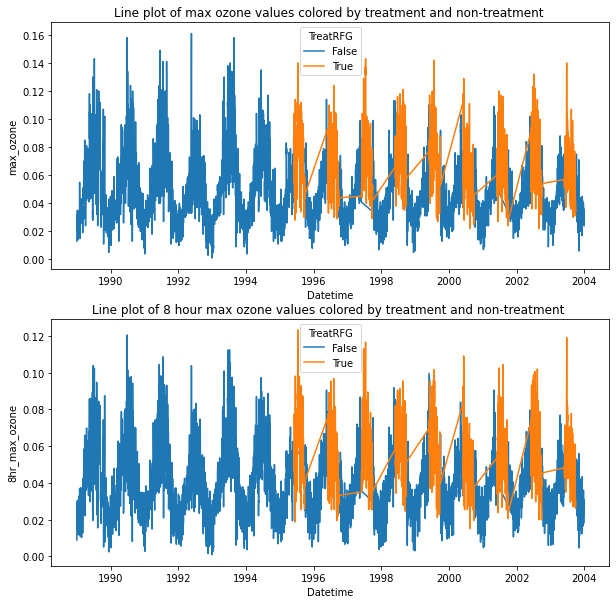

In [38]:
fig, [ax1, ax2] = plt.subplots(2,1,figsize = (10,10))

sns.lineplot(data = la_county_1601, x = "Datetime", y = "max_ozone", hue = "TreatRFG", ax = ax1)
ax1.set_title("Line plot of max ozone values colored by treatment and non-treatment ")


sns.lineplot(data = la_county_1601, x = "Datetime", y = "8hr_max_ozone", hue = "TreatRFG", ax = ax2)
ax2.set_title("Line plot of 8 hour max ozone values colored by treatment and non-treatment ")

fig.savefig("all_plot3.png")

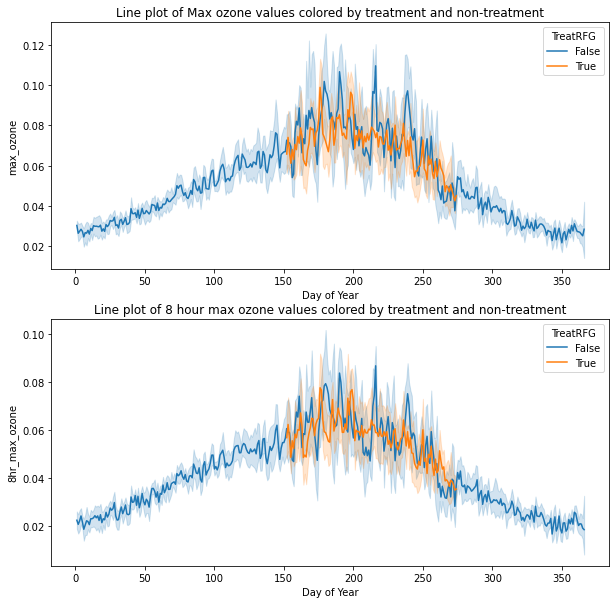

In [39]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize = (10,10))

sns.lineplot(data = la_county_1601, x = "day_of_year", y = "max_ozone", hue = "TreatRFG", ax = ax1)
ax1.set_title("Line plot of Max ozone values colored by treatment and non-treatment")

sns.lineplot(data = la_county_1601, x = "day_of_year", y = "8hr_max_ozone", hue = "TreatRFG", ax = ax2)
ax2.set_title("Line plot of 8 hour max ozone values colored by treatment and non-treatment")

ax1.set_xlabel("Day of Year")
ax2.set_xlabel("Day of Year")

fig.savefig("day_of_year_ozone3.png")


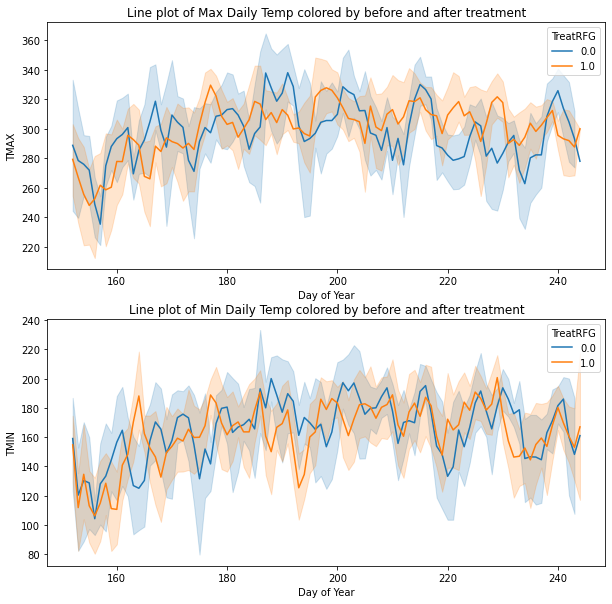

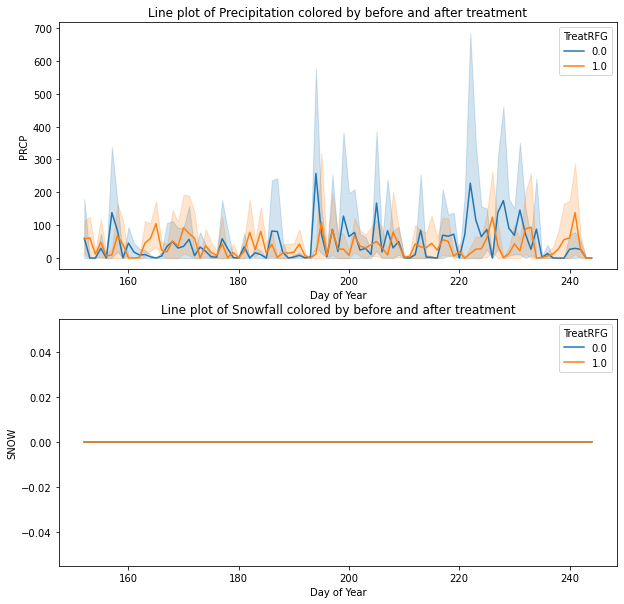

In [40]:
# to example the effect, let's just do difference in means lmao for the summer - main controls are all unchanged

#TMAX TMIN SNOW PRCP

la_county_summer_1601 = la_county_summer.copy()[la_county_summer["Site Num"] == 1001]
la_county_summer_1601["TMAX"] = la_county_summer_1601["TMAX"].astype(float)
la_county_summer_1601["TMIN"] = la_county_summer_1601["TMIN"].astype(float)
la_county_summer_1601["PRCP"] = la_county_summer_1601["PRCP"].astype(float)
la_county_summer_1601["SNOW"] = la_county_summer_1601["SNOW"].astype(float)



fig1, [ax1, ax2] = plt.subplots(2, 1, figsize = (10,10))
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMAX", hue = "TreatRFG", ax = ax1)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMIN", hue = "TreatRFG", ax = ax2)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "PRCP", hue = "TreatCARB", ax = ax3)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "SNOW", hue = "TreatCARB", ax = ax4)

ax1.set_title("Line plot of Max Daily Temp colored by before and after treatment")
ax2.set_title("Line plot of Min Daily Temp colored by before and after treatment")
# ax3.set_title("Line plot of Precipitation colored by before and after treatment")
# ax4.set_title("Line plot of Snowfall colored by before and after treatment")
ax1.set_xlabel("Day of Year")
ax2.set_xlabel("Day of Year")


fig2, [ax3, ax4] = plt.subplots(2, 1, figsize = (10,10))
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMAX", hue = "TreatCARB", ax = ax1)
# sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "TMIN", hue = "TreatCARB", ax = ax2)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "PRCP", hue = "TreatRFG", ax = ax3)
sns.lineplot(data = la_county_summer_1601, x = "day_of_year", y = "SNOW", hue = "TreatRFG", ax = ax4)

# ax1.set_title("Line plot of Max Daily Temp colored by before and after treatment")
# ax2.set_title("Line plot of Min Daily Temp colored by before and after treatment")
ax3.set_title("Line plot of Precipitation colored by before and after treatment")
ax4.set_title("Line plot of Snowfall colored by before and after treatment")

ax3.set_xlabel("Day of Year")
ax4.set_xlabel("Day of Year")

fig1.savefig("control_day_of_year3a.png")
fig2.savefig("control_day_of_year3b.png")


In [41]:
summer_days = la_county_summer_1601["day_of_year"].unique()
diff_max = []
diff_8hrmax = []
diff_max_log = []
diff_8hrmax_log = []

for i in summer_days:
    # calculate the mean of before and after and take the difference 
    day_i = la_county_summer_1601[la_county_summer_1601["day_of_year"] == i][["8hr_max_ozone", "max_ozone", "TreatRFG"]]
    before = day_i[day_i["TreatRFG"] == 0]
    after = day_i[day_i["TreatRFG"] == 1]
    mean_before_max = np.mean(before["max_ozone"])
    mean_before_8hrmax = np.mean(before["8hr_max_ozone"])
    mean_after_max = np.mean(after["max_ozone"])
    mean_after_8hrmax = np.mean(after["8hr_max_ozone"])
    
    diff_max.append(mean_after_max - mean_before_max)
    diff_8hrmax.append(mean_after_8hrmax - mean_before_8hrmax)
    
    mean_before_max_l = np.mean(np.log(before["max_ozone"]))
    mean_before_8hrmax_l = np.mean(np.log(before["8hr_max_ozone"]))
    mean_after_max_l = np.mean(np.log(after["max_ozone"]))
    mean_after_8hrmax_l = np.mean(np.log(after["8hr_max_ozone"]))
    
    diff_max_log.append(mean_after_max_l - mean_before_max_l)
    diff_8hrmax_log.append(mean_after_8hrmax_l - mean_before_8hrmax_l)
    
print("max", np.mean(diff_max), "8hr max", np.mean(diff_8hrmax), "log_max", np.mean(diff_max_log), "log_8hr_max", np.mean(diff_8hrmax_log))

max -0.004875981396142689 8hr max -0.002325938904534337 log_max -0.058448780898076765 log_8hr_max -0.03381899358541402
